<img src = "images/Logo.png" width = 220, align = "left">

<h1 align=center><font size = 6><span style="color:blue">Autocorrelation</span></font></h1>
<h2 align=center><font size = 5>Lab Exercise 3.13</font></h2>
<h3 align=center><font size = 4><b>Advanced Machine Learning Made Easy<br></b><small>From Theory to Practice with NumPy and scikit-learn<br><i>Volume 1: Generalized Linear Models</i></font></h3>

## Introduction

In this lab exercise, we will analyze the case when the errors are correlated with each other (also called serial correlation or autocorrelation when the correlation is through time). Our analysis will be focusing only on the case when the error is correlated with the error from the previous time period).
We will discuss three estimation methods of the feasible generalized linear regression (FGLS):
- Cochrane–Orcutt estimation procedure
- Prais-Winsten estimation procedure
- Hildreth–Lu estimation procedure

In the first part of the lab exercise, we will use a simple linear regression on a small dataset where we are interested in whether the number of employees of a metallurgical company depends on the number of employees of its vendor. In the second part of the lab exercise, we will use multiple linear regression to predict the icecream consumption as a function of price, temperature, and income. In both cases, we have time-series data, and the errors are serially correlated.

**Note:** *The first dataset, called 'Employee' was obtained from https://online.stat.psu.edu/stat501/, while the second dataset, called 'Icecream', was taken from "orcutt" package of R (see https://cran.r-project.org/web/packages/orcutt/orcutt.pdf)

**Note:** *The following python example was used in this notebook: https://web.pdx.edu/~crkl/ceR/Python/example10_3.py*

### Table of contents
1. [Fitting OLS on the 'Employee' dataset](#OLS-Employee)
2. [Introduction to Cochrane-Orcutt estimation procedure](#IntroOC)
3. [Cochrane-Orcutt and Prais-Winsten iterative estimation procedure](#IterativeOCPW)
4. [Hildreth–Lu estimation procedure](#GridSearch)
5. [Case study: Icecream consumption](#Icecream)

## 1. Fitting OLS on the 'Employee' dataset <a name="OLS-Employee"></a>

As a first step, let's import the libraries that we need.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

Next, load the 'Employee' dataset into a pandas dataframe, and print out the dataframe to have a visual inspection of the data.

In [2]:
data=pd.read_csv(os.path.join('data',"employee.txt"),sep='\t')
data

,Time,Vendor,Metal
0,1,322,44.2
1,2,317,44.3
2,3,319,44.4
3,4,323,43.4
4,5,327,42.8
5,6,328,44.3
6,7,325,44.4
7,8,326,44.8
8,9,330,44.4
9,10,334,43.1


The dataset gives the number of employees (in thousands) for a metal fabricator and one of their primary vendors for each month over a 5-year period, so $N = 60$. We have 
- "Metal" as the regressand represents the number of employees (in thousands) for a metal fabricator
- "Vendor" as the predictor represents the number of employees (in thousands) for the primary vendors

over the given time period. 

Let's fit a simple linear regression model on this dataset and plot the scatter plot and the estimated regression line.

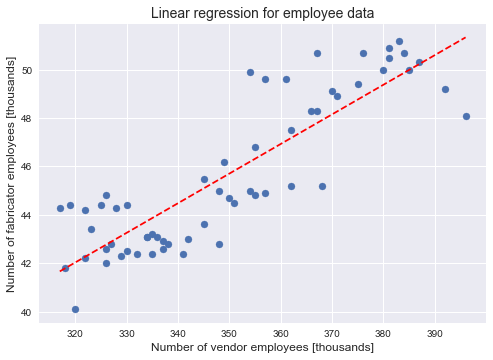

In [3]:
from sklearn.linear_model import LinearRegression
plt.style.use('seaborn')
x_=data['Vendor'].to_numpy().reshape(-1, 1)
y_=data['Metal'].to_numpy().reshape(-1, 1)
N=len(x_)
linregr=LinearRegression()
linregr.fit(x_,y_)
plt.scatter(x_,y_)
w_minmax=np.array([x_.min(),x_.max()]).reshape(-1, 1)
plt.plot(w_minmax,linregr.predict(w_minmax).reshape(-1, 1),'r--')
plt.xlabel("Number of vendor employees [thousands]",fontsize=12)
plt.ylabel("Number of fabricator employees [thousands]",fontsize=12)
plt.title("Linear regression for employee data",fontsize=14)
plt.show()

We may also plot the residual plot to have a visual inspection.

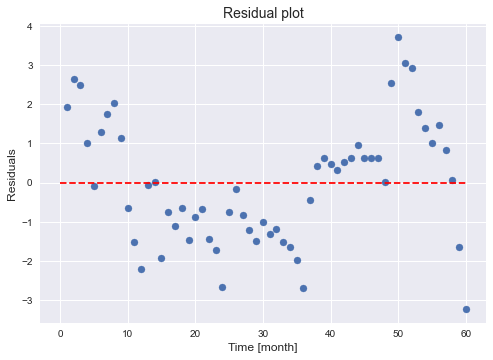

In [4]:
r_=y_-linregr.predict(x_)
t_=data['Time'].to_numpy().reshape(-1, 1)
plt.scatter(t_,r_)
plt.plot([[0],[60]],[[0],[0]],'r--')
plt.xlabel("Time [month]",fontsize=12)
plt.ylabel("Residuals",fontsize=12)
plt.title("Residual plot",fontsize=14)
plt.show()

Notice the non-random trend in the scatterplot. That might suggest autocorrelated errors are present. 
Let's create the OLS summary using the *statsmodels* library.

In [5]:
from statsmodels.formula.api import ols
model_ols = ols(formula = 'Metal ~ Vendor', data=data).fit()
print(model_ols.summary())
print("\nR-squared =",model_ols.rsquared)
print("RMSE =",np.sqrt(model_ols.mse_resid))

                            OLS Regression Results                            
Dep. Variable:                  Metal   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     168.8
Date:                Mon, 06 Sep 2021   Prob (F-statistic):           8.01e-19
Time:                        16:15:49   Log-Likelihood:                -111.94
No. Observations:                  60   AIC:                             227.9
Df Residuals:                      58   BIC:                             232.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8479      3.300      0.863      0.3

As can be seen, the Durbin-Watson statistic has a high value. To find the p-value for this test statistic, we need to look up a Durbin-Watson critical values table, which, in this case, indicates a highly significant p-value of approximately 0. (In general, a Durbin-Watson statistic close to 0 suggests significant positive autocorrelation.) 

Note: If $d_L<d_{DW}<d_U$ or $4-d_U<d_{DW}<4-d_L$ the test is inconclusive. The $d_L$ and $d_U$ values can be found here: https://www3.nd.edu/~wevans1/econ30331/Durbin_Watson_tables.pdf.

In this case we have for N=60 and k=1:
- $d_L=1.382$ and $d_U=1.449$ (thus, there is a positive autocorrelation)

You may call the Durbin-Watson statistical test directly to obtain the same result.

In [6]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(model_ols.resid)

0.3592395988284039

Alternatively, you may use the Breusch_Godfrey test (this is a more general test for autocorrelation, and it is more robust - see the book for more information).
The output from *statsmodels* is in the following order: 
- Lagrange multiplier test statistic,
- The p-value for Lagrange multiplier test,
- The value of the f statistic for the F test, an alternative version of the same test based on the F test for the parameter restriction,
- The pvalue for F test.

In [7]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
print(acorr_breusch_godfrey(model_ols,nlags=1))

(39.48178276044164, 3.3113415539125273e-10, 109.68114778541128, 6.728159197554716e-15)


Both the chi-square and F-test are significant, showing autocorrelation.

Because there is a positive autocorrelation of lag 1 in the error, the standard errors and RMSE of the OLS results might be underestimated. Thus, we need to use the feasible generalized least squares (FGLS) where the autocorrelation parameter $\rho$ from the equation

$\epsilon^{(i)}=\rho \cdot \epsilon^{(i-1)}+\eta^{(i)}$

will be estimated empirically (see the book about the description of the estimation procedure).

## 2. Introduction to Cochrane-Orcutt estimation procedure <a name="IntroOC"></a>

This estimation procedure starts by fitting the OLS regression on the data, which we have already done.
Next, a simple linear regression model without intercept will be fit
- with response variable equal to the residuals from the OLS above and 
- predictor variable equal to the lag 1 residuals from OLS 

to obtain the $\hat\rho$ estimate. For that, we create a dataframe containing the residuals from the previously fitted OLS and lag 1 residual (the first residual is dropped).

In [8]:
data_resid=pd.DataFrame(data=np.hstack([r_[1:,:],r_[:-1,:]]),columns=['resid','resid_lag1'])
data_resid

,resid,resid_lag1
0,2.638063,1.925855
1,2.493180,2.638063
2,1.003413,2.493180
3,-0.086354,1.003413
4,1.291204,-0.086354
5,1.758530,1.291204
6,2.036088,1.758530
7,1.146321,2.036088
8,-0.643446,1.146321
9,-1.510771,-0.643446


Next, fit a simple linear regression model without intercept on the data containing the residual and its lag 1 to obtain the slope estimate $\hat\rho$:

In [9]:
model_resid = ols(formula = 'resid ~ resid_lag1-1', data=data_resid).fit()
print(model_resid.summary(title="Residual regression results using lag1 residual as predictor"))
print("\nR-squared =",model_resid.rsquared)
print("RMSE =",np.sqrt(model_resid.mse_resid))

              Residual regression results using lag1 residual as predictor             
Dep. Variable:                  resid   R-squared (uncentered):                   0.659
Model:                            OLS   Adj. R-squared (uncentered):              0.653
Method:                 Least Squares   F-statistic:                              111.8
Date:                Mon, 06 Sep 2021   Prob (F-statistic):                    3.74e-15
Time:                        16:15:50   Log-Likelihood:                         -78.113
No. Observations:                  59   AIC:                                      158.2
Df Residuals:                      58   BIC:                                      160.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Create the transformations according to Cochrane-Orcutt procedure:<br>
$\left\{\begin{matrix}
	y^{(t)}_\star=y^{(t)}-\hat\rho \cdot y^{(t-1)} \\ 
	x^{(t)}_\star=x^{(t)}-\hat\rho\cdot x^{(t-1)}
\end{matrix}\right.$

In [10]:
rho=float(model_resid.params) # estimated rho value from OLS above
ystar_=y_[1:,:]-rho*y_[:-1,:]
xstar_=x_[1:,:]-rho*x_[:-1,:]
data_star=pd.DataFrame(data=np.hstack([xstar_,ystar_]),columns=['xstar','ystar'])
data_star

,xstar,ystar
0,49.294037,7.552784
1,55.450962,7.569645
2,57.788192,6.486507
3,58.462652,6.717892
4,56.137112,8.716723
5,52.305727,7.569645
6,55.799882,7.886507
7,58.968497,7.153953
8,59.642957,6.186507
9,59.317417,6.767307


Finally, fit the OLS model on the transformed data.

In [11]:
model_OC = ols(formula = 'ystar ~ xstar', data=data_star).fit()
print(model_OC.summary(title="Regression results after OC transformation {xstar,ystar}"))
print("\nR-squared =",model_OC.rsquared)
print("RMSE =",np.sqrt(model_OC.mse_resid))

           Regression results after OC transformation {xstar,ystar}           
Dep. Variable:                  ystar   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     13.60
Date:                Mon, 06 Sep 2021   Prob (F-statistic):           0.000505
Time:                        16:15:50   Log-Likelihood:                -64.474
No. Observations:                  59   AIC:                             132.9
Df Residuals:                      57   BIC:                             137.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8756      0.787      6.199      0.0

Then the original intercept would be:

In [12]:
w0=model_OC.params[0]/(1-rho)
print("Intercept =",w0)
print("Standard error of the intercept =",model_OC.bse[0]/(1-rho))

Intercept = 28.91557488412423
Standard error of the intercept = 4.664788831200779


The slope and its standard error remain the same. It should be noted that both the estimated regression coefficients and their standard error changed. Moreover, the standard error of the regression coefficients increased.

The Durbin-Watson statistics is now equal to $d_L$ showing still the presence of autocorrelation. Thus, we need to iterate the above steps until no autocorrelation is present.

## 3. Cochrane-Orcutt and Prais-Winsten iterative estimation procedure <a name="IterativeOCPW"></a>

The transformation suggested by Cochrane and Orcutt disregards the first observation of a time series, causing a loss of efficiency that can be substantial in small samples. A superior transformation, which retains the first observation with a weight of $\sqrt {(1-\rho ^{2})}$ was suggested first by Prais and Winsten.

In what follows, we will create a function that will iterate the above steps. 

As a first step, let's create a function that takes the model as the input, makes the OC or PW transformation, and fits the transformed input/outputs returning the fitted model.

In [13]:
import statsmodels.api as sm
def ols_star(model,rho,drop_1st=True):
    x = model.model.exog
    y = model.model.endog       # Create OC transformation
    ystar = y[1:]-rho*y[:-1]    # y*=y(t)-rho*y(t-1)
    xstar = x[1:,]-rho*x[:-1,]  # x*=x(t)-rho*x(t-1)
    if drop_1st == False:       # Create PW transformation (transforming 1st item input/output with weight sqrt(1-rho**2))
        ystar = np.append(np.sqrt(1-rho**2)*y[0],ystar)
        xstar = np.append([np.sqrt(1-rho**2)*x[0,]],xstar,axis=0)
    model_star = sm.OLS(ystar,xstar).fit()
    model_star.model.exog_names[:] = model.model.exog_names # pass the exogonous names
    return(model_star)

Next, let's create the Cochrane–Orcutt and Prais-Winsten iterative estimator described in the book and shown in the pseudocode.

In [14]:
def CO_FW_proc(model,drop_1st=True):
    x = model.model.exog
    y = model.model.endog
    rorig_=np.array(model.resid)[:,np.newaxis]
    r_=rorig_[1:,:]                                  # r(t)
    rlag_=rorig_[:-1,:]                              # r(t-1)
    rho=float((r_.T@rlag_)/(rlag_.T@rlag_))          # Estimate rho (taking usege that residuals's mean is close to zero)
    rhodiff = 1.0
    iter=1
    while(rhodiff>1.0e-8):                           # Iterate until convergence (no change in rho up to 8 decimals)
        model_star = ols_star(model,rho,drop_1st)    # fit the transformed data, then calculate the residuals with original data
        rnew_=(y - (x @ model_star.params))[:,np.newaxis]
        r_=rnew_[1:,:]                               # r(t)
        rlag_=rnew_[:-1,:]                           # r(t-1)
        rhonew=float((r_.T@rlag_)/(rlag_.T@rlag_))   # Estimate rho (taking usege that residuals's mean is close to zero)
        rhodiff = np.abs(rhonew-rho)
        rho = rhonew
        print("Iter =",iter,end =" ");print('=> Rho =', rho)
        iter+=1
    new_model = ols_star(model,rho,drop_1st)
    return(new_model)

Finally, use the defined function to apply the Cochrane-Orcutt iterative procedure on the 'Employee' dataset. 

In [15]:
ols_co = CO_FW_proc(model_ols)
print(ols_co.summary(title="Regression results after OC transformation {xstar,ystar}"))
print("\nR-squared =",ols_co.rsquared)
print("RMSE =",np.sqrt(ols_co.mse_resid))

Iter = 1 => Rho = 0.9564461602821356
Iter = 2 => Rho = 0.9712560679996847
Iter = 3 => Rho = 0.972978705540022
Iter = 4 => Rho = 0.9733622490049562
Iter = 5 => Rho = 0.9734571078843758
Iter = 6 => Rho = 0.9734811489467019
Iter = 7 => Rho = 0.973487279222746
Iter = 8 => Rho = 0.9734888448193058
Iter = 9 => Rho = 0.9734892448115008
Iter = 10 => Rho = 0.9734893470153064
Iter = 11 => Rho = 0.9734893731305349
Iter = 12 => Rho = 0.9734893798035709
           Regression results after OC transformation {xstar,ystar}           
Dep. Variable:                      y   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     2.841
Date:                Mon, 06 Sep 2021   Prob (F-statistic):             0.0974
Time:                        16:15:50   Log-Likelihood:                -57.420
No. Observations:                  59   AIC:                             118.8
Df

The Durbin Watson statistic is now greater than $d_L=1.382$ but less than $4-d_U=4-1.449=2.551$. Thus, this test is inconclusive. We may try with the Breusch-Godfrey statistical test:

In [16]:
print(acorr_breusch_godfrey(ols_co,nlags=1))

(0.0992884561212497, 0.7526851910484422, 0.0943987499819516, 0.7597975063789512)


This statistical test confirms that there is no autocorrelation of lag 1 present. We can also create the scatter plot of the residuals to have a visual inspection.

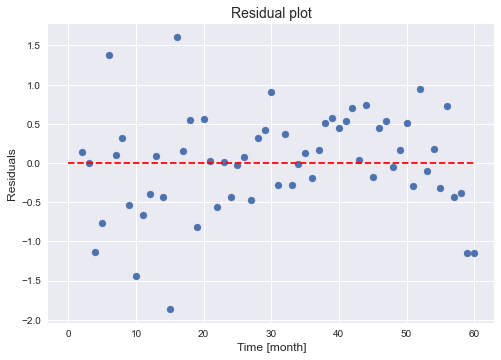

In [17]:
plt.scatter(t_[1:,:],ols_co.resid)
plt.plot([[0],[60]],[[0],[0]],'r--')
plt.xlabel("Time [month]",fontsize=12)
plt.ylabel("Residuals",fontsize=12)
plt.title("Residual plot",fontsize=14)
plt.show()

There is one problem, though. In the initial OLS, we could draw an inference based on the t-statistics (namely, that the regression coefficient for the 'Vendor' is significantly different from zero). However, with the new OLS model, this is not true anymore. Looking at the F-statistics, we can conclude that our model is not better than using the mean of the output. Thus, we can infer, there is no linear relationship between the number of employees of the metal fabricator and its primary vendors.

We may obtain a similar result using the Prais-Winsten estimation procedure:

In [18]:
ols_fw = CO_FW_proc(model_ols,drop_1st=False)
print(ols_fw.summary())

Iter = 1 => Rho = 0.9561204180391542
Iter = 2 => Rho = 0.97137179901464
Iter = 3 => Rho = 0.9719507178777365
Iter = 4 => Rho = 0.9719670154915063
Iter = 5 => Rho = 0.9719674681206314
Iter = 6 => Rho = 0.97196748068654
Iter = 7 => Rho = 0.9719674810353915
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.899
Model:                            OLS   Adj. R-squared (uncentered):              0.895
Method:                 Least Squares   F-statistic:                              257.3
Date:                Mon, 06 Sep 2021   Prob (F-statistic):                    1.45e-29
Time:                        16:15:50   Log-Likelihood:                         -58.037
No. Observations:                  60   AIC:                                      120.1
Df Residuals:                      58   BIC:                                      124.3
Df Model:                           2    

The Breusch-Godfrey statistical test also confirms that there is no autocorrelation of lag 1 in error.

In [19]:
print(acorr_breusch_godfrey(ols_fw,nlags=1))

(0.27680192997044495, 0.5988050476572828, 0.09311412744247384, 0.7613862136433153)


## 4. Hildreth–Lu estimation procedure <a name="GridSearch"></a>

The Hildreth-Lu estimation procedure is a more direct method for estimating $\rho$. It represents a grid search by selecting a series of candidate values for $\rho$ between $-1$ and $+1$ and for each candidate value, applies OLS on the transformed input and output variables. The procedure retains the RSS value for each of these OLS regression and selects the value as an estimate of $\rho$ for which the RSS is minimized.

Let's create a function for this grid search:

In [20]:
def HL_proc(model,rhovals):
    RSS=[]
    x = model.model.exog
    y = model.model.endog
    for rho in rhovals:
        model_star = ols_star(model,rho,drop_1st=True)
        r_=np.array(model_star.resid)[:,np.newaxis]
        RSS.append(float(r_.T@r_))
    return RSS 

Create the plot of the RSS values as a function of $\rho$.

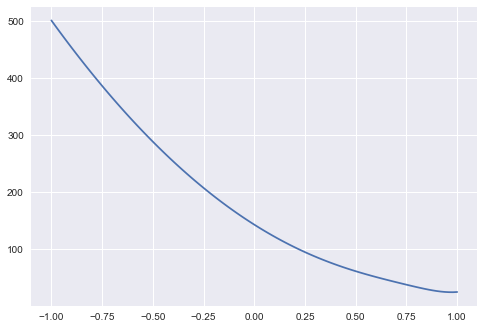

In [21]:
rho=np.linspace(-1,1,100)
rss=HL_proc(model_ols,rho)
plt.plot(rho,rss)
plt.show()

We can decrease the range for sweeping to clearly observe the quadratic function near 1.

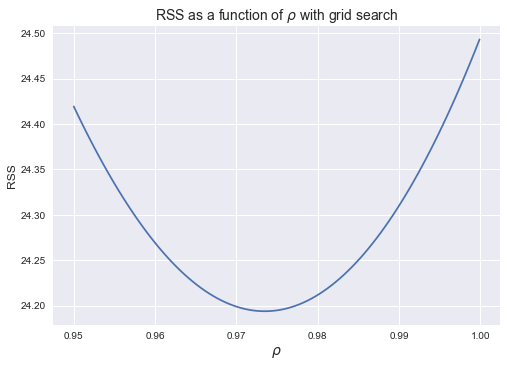

In [22]:
rho=np.linspace(0.95,0.9999,100)
rss=HL_proc(model_ols,rho)
plt.plot(rho,rss)
plt.xlabel(r"$\rho$",fontsize=14)
plt.ylabel("RSS",fontsize=12)
plt.title(r"RSS as a function of $\rho$ with grid search",fontsize=14)
plt.show()

The RSS is minimal for the following $\rho$ value:

In [23]:
print("rho (when RSS min.)=",rho[np.array(rss).argmin()])

rho (when RSS min.)= 0.973689898989899


## 5. Case study: Icecream consumption <a name="Icecream"></a>

In the first case, we had a simple linear regression. Let's see how does the above Cochrane-Orcutt estimation applies to multiple linear regression.
In this exercise, we want to predict the ice cream consumption (which might be important for an ice cream producer to know how much the production shall be increased or decreased).

**Note:**: *The first two lines can be also used to obtain the dataset.*

In [24]:
#from statsmodels.datasets import get_rdataset
#get_rdataset("icecream","orcutt")

data=pd.read_csv(os.path.join('data',"icecream.csv"),sep=',')
data

,price,cons,income,temp
0,0.270,0.386,78,41
1,0.282,0.374,79,56
2,0.277,0.393,81,63
3,0.280,0.425,80,68
4,0.272,0.406,76,69
5,0.262,0.344,78,65
6,0.275,0.327,82,61
7,0.267,0.288,79,47
8,0.265,0.269,76,32
9,0.277,0.256,79,24


The dataset contains four weekly observations from 1951-03-18 to 1953-07-11 in the United States (30 observations)
The dataset contains the following 4 variables.
- price: the price of ice cream (per pint);
- cons: consumption of ice cream per head (in pints);
- income: average family income per week (in US Dollars);
- temp: average temperature (in Fahrenheit);

For visualization purposes, let's create the DateTime index.

In [25]:
data.set_index(pd.date_range(start='18/3/1951', end='11/07/1953', periods=30),inplace=True)
data

,price,cons,income,temp
1951-03-18 00:00:00.000000000,0.270,0.386,78,41
1951-04-20 06:37:14.482758620,0.282,0.374,79,56
1951-05-23 13:14:28.965517241,0.277,0.393,81,63
1951-06-25 19:51:43.448275862,0.280,0.425,80,68
1951-07-29 02:28:57.931034482,0.272,0.406,76,69
1951-08-31 09:06:12.413793102,0.262,0.344,78,65
1951-10-03 15:43:26.896551724,0.275,0.327,82,61
1951-11-05 22:20:41.379310344,0.267,0.288,79,47
1951-12-09 04:57:55.862068964,0.265,0.269,76,32
1952-01-11 11:35:10.344827584,0.277,0.256,79,24


Then create the plot of each variable as a function of time.

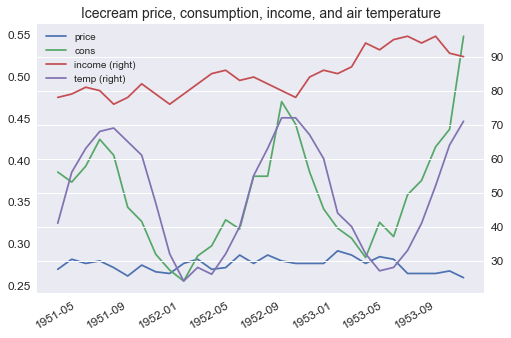

In [26]:
data.plot(subplots=False,sharex=True,secondary_y=['income','temp'],fontsize=12)
plt.title("Icecream price, consumption, income, and air temperature",fontsize=14)
plt.show()

As can be seen, the price of the ice cream remains the same with some small fluctuations, while there is an increasing trend in the income. The graph suggests that the temperature is an important determinant for the consumption of ice cream.

Let's fit the OLS model on the data.

In [27]:
from statsmodels.formula.api import ols
model = ols(formula = 'cons ~ price + income + temp', data=data).fit()
print(model.summary())
print("RMSE =",np.sqrt(model.mse_resid))

                            OLS Regression Results                            
Dep. Variable:                   cons   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     22.17
Date:                Mon, 06 Sep 2021   Prob (F-statistic):           2.45e-07
Time:                        16:15:52   Log-Likelihood:                 58.619
No. Observations:                  30   AIC:                            -109.2
Df Residuals:                      26   BIC:                            -103.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1973      0.270      0.730      0.4

The result is quite good, although the Durbin-Watson statistics is in the inconclusive region ($d_L= 1.006$ and $d_U=1.421$). Let's check for autocorrelation using the Breusch-Godfrey test.

In [28]:
print(acorr_breusch_godfrey(model,nlags=1))

(4.237063546386795, 0.03955051727086634, 4.1115883218667015, 0.05337551325603645)


While the chi-square test is not significant (but we have a small sample), the F-test is. So we may conclude that there is still autocorrelation in error. Let's create the scatter plot of the residuals.

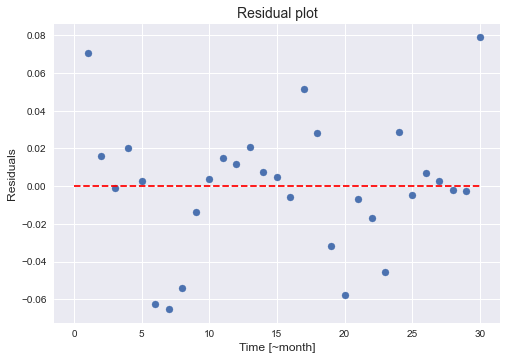

In [29]:
plt.scatter(np.arange(1,31,1),model.resid)
plt.plot([[0],[30]],[[0],[0]],'r--')
plt.xlabel("Time [~month]",fontsize=12)
plt.ylabel("Residuals",fontsize=12)
plt.title("Residual plot",fontsize=14)
plt.show()

Using the Cochrane-Orcutt iterative estimation procedure, let's estimate the autocorrelation parameter $\rho$ and fit the new OLS model.

In [30]:
model_co = CO_FW_proc(model,drop_1st=True)
print(model_co.summary())
print("RMSE =",np.sqrt(model_co.mse_resid))

Iter = 1 => Rho = 0.4008341999596179
Iter = 2 => Rho = 0.40089710784090804
Iter = 3 => Rho = 0.40091675074448446
Iter = 4 => Rho = 0.400922885925552
Iter = 5 => Rho = 0.4009248023287948
Iter = 6 => Rho = 0.40092540095843243
Iter = 7 => Rho = 0.4009255879548099
Iter = 8 => Rho = 0.40092564636778766
Iter = 9 => Rho = 0.4009256646145615
Iter = 10 => Rho = 0.400925670314426
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     15.40
Date:                Mon, 06 Sep 2021   Prob (F-statistic):           7.01e-06
Time:                        16:15:52   Log-Likelihood:                 60.906
No. Observations:                  29   AIC:                            -113.8
Df Residuals:                      25   BIC:                            -1

The Durbin-Watson statistic is still inconclusive, so let's check the presence of autocorrelation with the Breusch-Godfrey test.

In [31]:
print(acorr_breusch_godfrey(model_co,nlags=1))

(0.32559241964845154, 0.5682660301142344, 0.2725154146486177, 0.6064344957701945)


Now, both the chi-square and F-test are not significant. Thus, we can reject the null hypothesis of having autocorrelation of lag 1.

We may create the scatter plot of the residuals from the new OLS model for visual inspection.

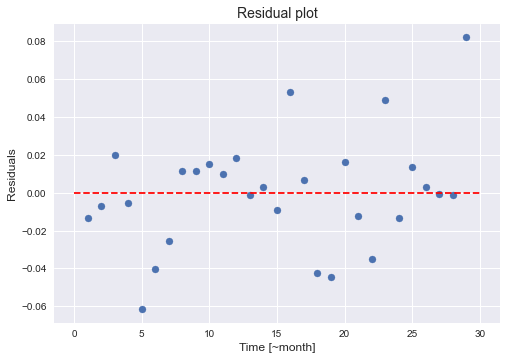

In [32]:
plt.scatter(np.arange(1,30,1),model_co.resid)
plt.plot([[0],[30]],[[0],[0]],'r--')
plt.xlabel("Time [~month]",fontsize=12)
plt.ylabel("Residuals",fontsize=12)
plt.title("Residual plot",fontsize=14)
plt.show()

So far, so good. But there is a problem. When checking the t-statistics, the regression coefficient for the price is not significantly different from zero, and the same is almost true for the income.

Sometimes, the finding of autocorrelation may be an indication that there is something wrong with the model. A possible way to eliminate the autocorrelation is to change the model specification, like including lagged variables. In particular, we will include the lagged temperature in the model.

Let's create this dataset.

In [33]:
datalag=data.drop(pd.Timestamp('1951-03-18'))
datalag['temp_lag1']=np.array(data['temp'][:-1])
datalag

,price,cons,income,temp,temp_lag1
1951-04-20 06:37:14.482758620,0.282,0.374,79,56,41
1951-05-23 13:14:28.965517241,0.277,0.393,81,63,56
1951-06-25 19:51:43.448275862,0.280,0.425,80,68,63
1951-07-29 02:28:57.931034482,0.272,0.406,76,69,68
1951-08-31 09:06:12.413793102,0.262,0.344,78,65,69
1951-10-03 15:43:26.896551724,0.275,0.327,82,61,65
1951-11-05 22:20:41.379310344,0.267,0.288,79,47,61
1951-12-09 04:57:55.862068964,0.265,0.269,76,32,47
1952-01-11 11:35:10.344827584,0.277,0.256,79,24,32
1952-02-13 18:12:24.827586204,0.282,0.286,82,28,24


And fit the regression model using this lagged temperature variable.

In [34]:
newmodel = ols(formula = 'cons ~ price + income + temp + temp_lag1', data=datalag).fit()
print(newmodel.summary())
print("RMSE =",np.sqrt(newmodel.mse_resid))

                            OLS Regression Results                            
Dep. Variable:                   cons   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     28.98
Date:                Mon, 06 Sep 2021   Prob (F-statistic):           7.10e-09
Time:                        16:15:52   Log-Likelihood:                 63.416
No. Observations:                  29   AIC:                            -116.8
Df Residuals:                      24   BIC:                            -110.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1895      0.232      0.816      0.4

The Durbin-Watson statistics s inconclusive, so let's check the presence of autocorrelation with the Breusch-Godfrey test.

In [35]:
print(acorr_breusch_godfrey(newmodel,nlags=1))

(0.1198540175469549, 0.7291928732171367, 0.09545112428638035, 0.7601395676609697)


As can be seen, with the model using lagged temperature variable, there is no autocorrelation in the error term when using the original data.

Let's fit another regression model, but at this time, leaving out the 'price' predictor and the intercept.

In [36]:
newmodel = ols(formula = 'cons ~ income + temp + temp_lag1-1', data=datalag).fit()
print(newmodel.summary())
print("RMSE =",np.sqrt(newmodel.mse_resid))

                                 OLS Regression Results                                
Dep. Variable:                   cons   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                              1433.
Date:                Mon, 06 Sep 2021   Prob (F-statistic):                    5.57e-29
Time:                        16:15:53   Log-Likelihood:                          62.279
No. Observations:                  29   AIC:                                     -118.6
Df Residuals:                      26   BIC:                                     -114.5
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The centered adjusted R-squared value is:

In [37]:
linregr.set_params(fit_intercept=False)
linregr.fit(datalag[['income','temp','temp_lag1']],datalag['cons'])
R2=linregr.score(datalag[['income','temp','temp_lag1']],datalag['cons'])
N=29;D=3
print("Adjusted R2 =",1-(1-R2)*(N-1)/(N-D-1))

Adjusted R2 = 0.7922213285989048


<img src = "images/AML1-Cover.png" width = 110, align = "left" style="margin:0px 20px">

<span style="color:blue">**Note:**</span> This Jupyter Notebook is accompanying the book: <br> $\qquad$ <b>Advanced Machine Learning Made Easy</b> <br> $\qquad$ From Theory to Practice with NumPy and scikit-learn <br> $\qquad$ <i> Volume 1: Generalized Linear Models</i><br>
by Ferenc Farkas, Ph.D. 

If you find this Notebook useful, please support me by buying the book at [Leanpub](http://leanpub.com/AML1). <br>
Copyright notice: This Jupyter Notebook is made available under the [MIT License](https://opensource.org/licenses/MIT).